In [76]:
import pandas as pd
import numpy as np


## Processing of Data

In [77]:
# Load Data
spot_df = pd.read_csv("Nifty_spot_data_min_2024.csv", parse_dates=["timestamp"])
call_df = pd.read_csv("Call-Option-Data-1min.csv", parse_dates=["timestamp"])
put_df = pd.read_csv("Put-Option-Data-1min.csv", parse_dates=["timestamp"])


In [78]:
spot_df.head()

,timestamp,Open,High,Low,Close,expiry
0,01-01-2024 09:15,21727.8,21737.3,21701.8,21710.4,04-01-2024
1,01-01-2024 09:16,21711.5,21720.0,21695.1,21695.3,04-01-2024
2,01-01-2024 09:17,21697.7,21711.8,21694.8,21709.6,04-01-2024
3,01-01-2024 09:18,21709.1,21712.5,21698.4,21701.6,04-01-2024
4,01-01-2024 09:19,21704.3,21708.0,21693.6,21693.8,04-01-2024


In [79]:
call_df.head()

,timestamp,OptionType,Strike,Expiry,Open,High,Low,Close
0,2024-11-04 09:15:00,CE,23700,07-11-2024,601.85,601.85,569.75,569.75
1,2024-11-04 09:15:00,CE,25300,07-11-2024,2.25,2.95,1.85,1.95
2,2024-11-04 09:15:00,CE,25400,07-11-2024,2.00,2.00,1.60,1.75
3,2024-11-04 09:15:00,CE,24250,07-11-2024,228.00,228.00,179.10,184.90
4,2024-11-04 09:15:00,CE,26600,07-11-2024,1.00,1.50,1.00,1.30


In [80]:
spot_df['timestamp'] = pd.to_datetime(spot_df['timestamp'], dayfirst=True)
call_df['timestamp'] = pd.to_datetime(call_df['timestamp'], dayfirst=True)
put_df['timestamp'] = pd.to_datetime(put_df['timestamp'], dayfirst=True)

In [81]:
spot_df.head()

,timestamp,Open,High,Low,Close,expiry
0,2024-01-01 09:15:00,21727.8,21737.3,21701.8,21710.4,04-01-2024
1,2024-01-01 09:16:00,21711.5,21720.0,21695.1,21695.3,04-01-2024
2,2024-01-01 09:17:00,21697.7,21711.8,21694.8,21709.6,04-01-2024
3,2024-01-01 09:18:00,21709.1,21712.5,21698.4,21701.6,04-01-2024
4,2024-01-01 09:19:00,21704.3,21708.0,21693.6,21693.8,04-01-2024


In [82]:
call_df.head()

,timestamp,OptionType,Strike,Expiry,Open,High,Low,Close
0,2024-11-04 09:15:00,CE,23700,07-11-2024,601.85,601.85,569.75,569.75
1,2024-11-04 09:15:00,CE,25300,07-11-2024,2.25,2.95,1.85,1.95
2,2024-11-04 09:15:00,CE,25400,07-11-2024,2.00,2.00,1.60,1.75
3,2024-11-04 09:15:00,CE,24250,07-11-2024,228.00,228.00,179.10,184.90
4,2024-11-04 09:15:00,CE,26600,07-11-2024,1.00,1.50,1.00,1.30


In [83]:
# Preprocessing
spot_df['date'] = spot_df['timestamp'].dt.date
call_df['date'] = call_df['timestamp'].dt.date
put_df['date'] = put_df['timestamp'].dt.date


In [84]:
spot_df.head()

,timestamp,Open,High,Low,Close,expiry,date
0,2024-01-01 09:15:00,21727.8,21737.3,21701.8,21710.4,04-01-2024,2024-01-01
1,2024-01-01 09:16:00,21711.5,21720.0,21695.1,21695.3,04-01-2024,2024-01-01
2,2024-01-01 09:17:00,21697.7,21711.8,21694.8,21709.6,04-01-2024,2024-01-01
3,2024-01-01 09:18:00,21709.1,21712.5,21698.4,21701.6,04-01-2024,2024-01-01
4,2024-01-01 09:19:00,21704.3,21708.0,21693.6,21693.8,04-01-2024,2024-01-01


## Backtesting Implementation

In [85]:
# Backtest Parameters
entry_time = "13:00:00"
exit_time = "15:00:00"
quantity = 25
sl_pct = 0.30

# Output Trade Log
trade_log = []


In [86]:
# Backtest Loop
for date in spot_df['date'].unique():  #looking for unique dates
    day_spot = spot_df[spot_df['date'] == date] #putting the values of same date together
    if entry_time not in day_spot['timestamp'].dt.time.astype(str).values:  # if entry time (13:00:00) for that date is not present continue
        continue

    entry_row = day_spot[day_spot['timestamp'].dt.time == pd.to_datetime(entry_time).time()]  #the row with the entry time value
    if entry_row.empty:
        continue

    # Fix: Use 50-point rounding
    spot_price = round(entry_row['Close'].values[0] / 50.0) * 50      #conversion of spot price to end in multiple of 50
    ce_strike = spot_price + 100
    pe_strike = spot_price - 100

    # Option data for the selected strikes
    ce_data = call_df[(call_df['date'] == date) & (call_df['Strike'] == ce_strike)]   # taking out data of call price for that date and that strike price
    pe_data = put_df[(put_df['date'] == date) & (put_df['Strike'] == pe_strike)]      # taking out data of put price for that date and that strike price

    ce_entry = ce_data[ce_data['timestamp'].dt.time == pd.to_datetime(entry_time).time()]   #taking out data from ce_data (the required strike price) at the time of entry
    pe_entry = pe_data[pe_data['timestamp'].dt.time == pd.to_datetime(entry_time).time()]   #taking out data from ce_data (the required strike price) at the time of exit

    if ce_entry.empty or pe_entry.empty:      #if any of these is empty continue
        continue

    ce_entry_price = ce_entry['Close'].values[0]
    pe_entry_price = pe_entry['Close'].values[0]
    ce_sl = ce_entry_price * (1 + sl_pct)
    pe_sl = pe_entry_price * (1 + sl_pct)

    ce_exit_price, pe_exit_price = None, None
    ce_exit_type, pe_exit_type = "expiry over", "expiry over"
    ce_exit_time = f"{date} {exit_time}"
    pe_exit_time = f"{date} {exit_time}"
    ce_active, pe_active = True, True

    # Iterate over timestamps
    for t in sorted(set(ce_data['timestamp']) & set(pe_data['timestamp'])):   #Traversing through the ce and pe data for every min, in a sorted manner according to time
        if t.time() <= pd.to_datetime(entry_time).time() or t.time() > pd.to_datetime(exit_time).time():    # if time (t) is less than entry and more than exit ignore
            continue

        ce_row = ce_data[ce_data['timestamp'] == t]
        pe_row = pe_data[pe_data['timestamp'] == t]

        if ce_active and ce_row['High'].values[0] >= ce_sl:   #if call is active and ce high value breaches sl then exit the option
            ce_exit_price = ce_sl
            ce_exit_type = "stoploss hit"
            ce_exit_time = t.strftime("%Y-%m-%d %H:%M:%S")
            ce_active = False
            if pe_active:
                pe_sl = pe_entry_price  # minimize the cost and ensure only one of the option is generating loss

        if pe_active and pe_row['High'].values[0] >= pe_sl:
            pe_exit_price = pe_sl
            pe_exit_type = "stoploss hit"
            pe_exit_time = t.strftime("%Y-%m-%d %H:%M:%S")
            pe_active = False
            if ce_active:
                ce_sl = ce_entry_price  # minimize the cost and ensure only one of the option is generating loss

        if not ce_active and not pe_active:
            break

    # Exit at 3:00 PM if still active
    if ce_active:
        ce_exit = ce_data[ce_data['timestamp'].dt.time == pd.to_datetime(exit_time).time()]
        if not ce_exit.empty:
            ce_exit_price = ce_exit['Close'].values[0]
            ce_exit_time = pd.to_datetime(ce_exit['timestamp'].values[0]).strftime("%Y-%m-%d %H:%M:%S")


    if pe_active:
        pe_exit = pe_data[pe_data['timestamp'].dt.time == pd.to_datetime(exit_time).time()]
        if not pe_exit.empty:
            pe_exit_price = pe_exit['Close'].values[0]
            pe_exit_time = pd.to_datetime(pe_exit['timestamp'].values[0]).strftime("%Y-%m-%d %H:%M:%S")



    # Record trades
    ce_pnl = (ce_entry_price - ce_exit_price) * quantity
    pe_pnl = (pe_entry_price - pe_exit_price) * quantity

    trade_log.append({
        "Key": f"{date} {entry_time}",
        "ExitTime": ce_exit_time,
        "Symbol": f"BANKNIFTY{date.strftime('%d%b%y').upper()}{ce_strike}CE",
        "EntryPrice": ce_entry_price,
        "ExitPrice": ce_exit_price,
        "Quantity": quantity,
        "PositionStatus": -1,
        "Pnl": round(ce_pnl, 2),
        "ExitType": ce_exit_type
    })

    trade_log.append({
        "Key": f"{date} {entry_time}",
        "ExitTime": pe_exit_time,
        "Symbol": f"BANKNIFTY{date.strftime('%d%b%y').upper()}{pe_strike}PE",
        "EntryPrice": pe_entry_price,
        "ExitPrice": pe_exit_price,
        "Quantity": quantity,
        "PositionStatus": -1,
        "Pnl": round(pe_pnl, 2),
        "ExitType": pe_exit_type
    })

In [87]:
# Export Trade Log
df_log = pd.DataFrame(trade_log)
df_log.to_csv("short_strangle_trade_log.csv", index=False)
print("Trade log saved to 'short_strangle_trade_log.csv'")

Trade log saved to 'short_strangle_trade_log.csv'


Max Drawdown: ₹-1479.38


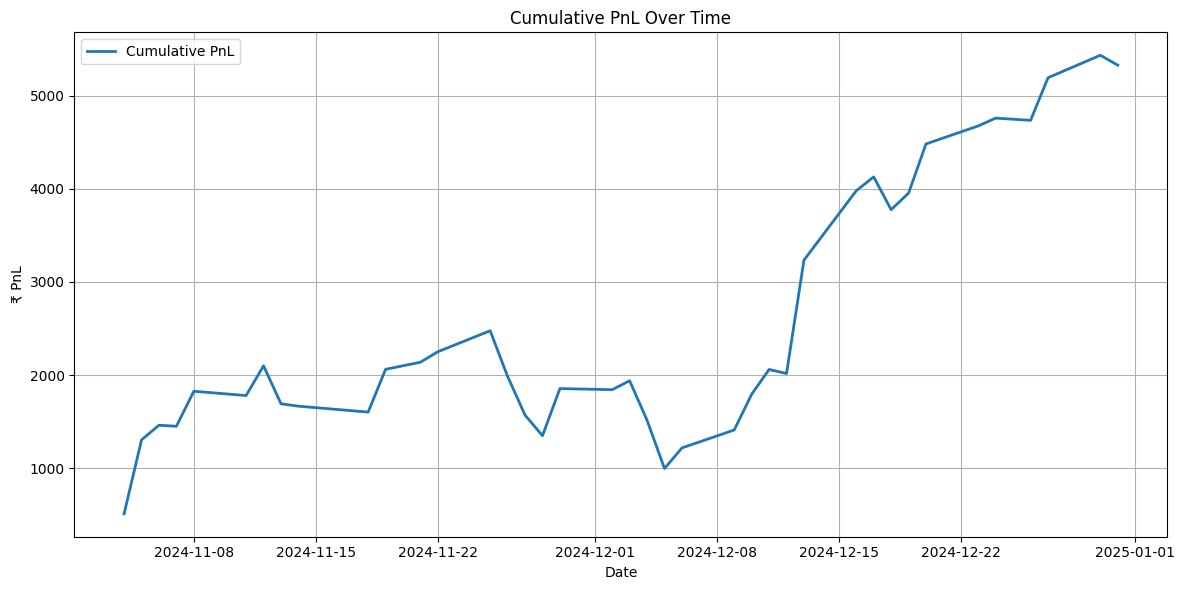

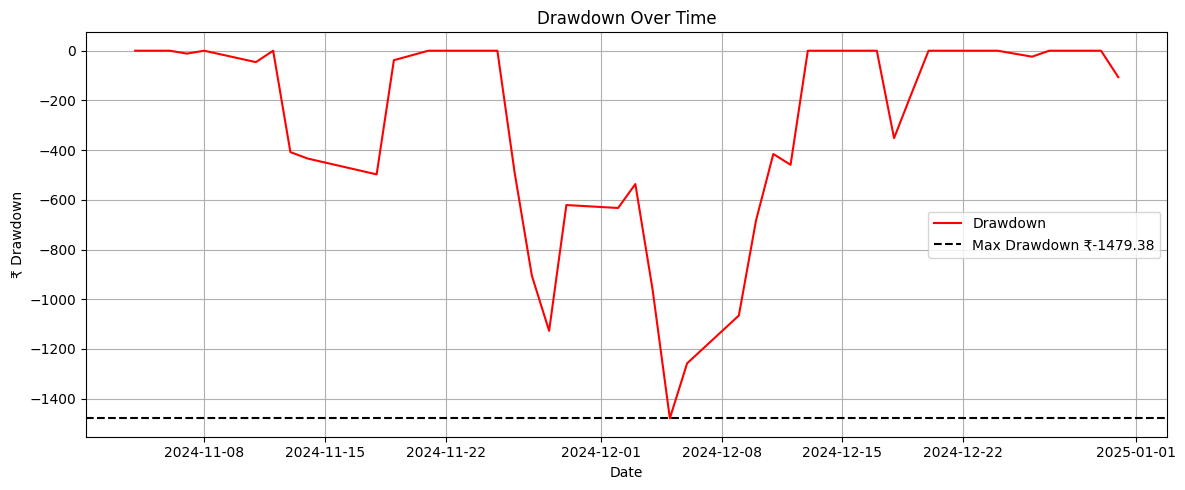

In [91]:
import matplotlib.pyplot as plt

# Load Trade Log
df = pd.read_csv("short_strangle_trade_log.csv", parse_dates=["ExitTime"])
df = df.sort_values("ExitTime")

# Aggregate Daily PnL
df['ExitDate'] = df['ExitTime'].dt.date
daily_pnl = df.groupby('ExitDate')['Pnl'].sum()

# Cumulative PnL
cumulative_pnl = daily_pnl.cumsum()

# Max Drawdown
rolling_max = cumulative_pnl.cummax()
drawdown = cumulative_pnl - rolling_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: ₹{max_drawdown:.2f}")


# Plot Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(cumulative_pnl, label='Cumulative PnL', linewidth=2)
plt.title("Cumulative PnL Over Time")
plt.xlabel("Date")
plt.ylabel("₹ PnL")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Drawdown
plt.figure(figsize=(12, 5))
plt.plot(drawdown, color='red', label='Drawdown')
plt.axhline(max_drawdown, color='black', linestyle='--', label=f"Max Drawdown ₹{max_drawdown:.2f}")
plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("₹ Drawdown")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
